In [1]:
import pandas as pd
import seaborn as sns
from textblob import TextBlob
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
bnb_data = pd.read_csv('../src/data/sf_airbnb_listings.csv')

In [3]:
bnb_data.dtypes

id                                                int64
listing_url                                      object
scrape_id                                       float64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

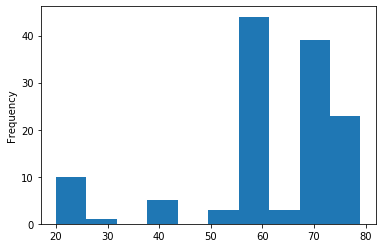

In [4]:
bnb_data.query('review_scores_rating < 80')['review_scores_rating'].plot.hist()

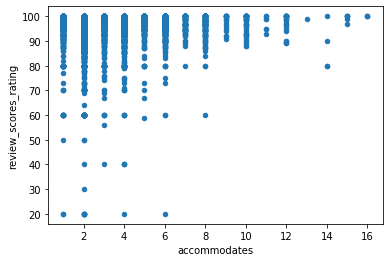

In [5]:
bnb_data.plot.scatter(x='accommodates', y='review_scores_rating')

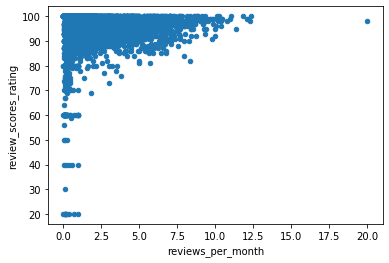

In [6]:
bnb_data.plot.scatter(x='reviews_per_month', y='review_scores_rating')

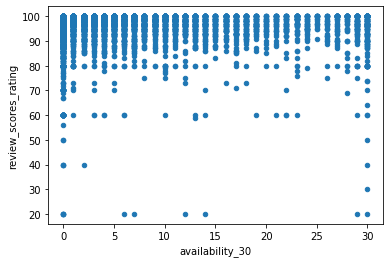

In [7]:
bnb_data.plot.scatter(x='availability_30', y='review_scores_rating')

In [8]:
bnb_data = bnb_data.query('not house_rules.isnull() and not summary.isnull() and not space.isnull() and not description.isnull()')

In [26]:
text_cols = ['house_rules', 'summary', 'space', 'description']

def text_len(row):
    total = 0
    for col in text_cols:
        total += len(row[col])
    return total

def analyze_tone(row):
    total = 0
    for col in text_cols:
        blob = TextBlob(row[col])
        total += blob.sentiment.polarity
        
    return total

bnb_data['sentiment'] = bnb_data.apply(
    lambda r: analyze_tone(r),
    axis=1
)

bnb_data['text_len'] = bnb_data.apply(
    lambda r: text_len(r),
    axis=1
)

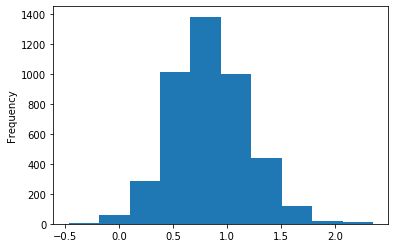

In [10]:
bnb_data['sentiment'].plot.hist()

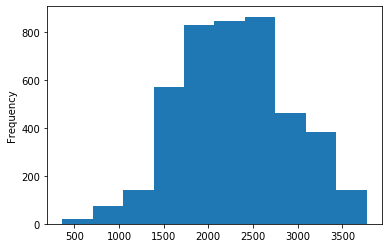

In [27]:
bnb_data['text_len'].plot.hist()

In [12]:
bnb_data.query('sentiment > 1.5')['description']

28      When people visit our home they never want to ...
39      You will love staying in this great apartment ...
71      This 9'''' x 12'''' cottage is in the garden o...
126     The comfy in-law apartment of our historic Vic...
129     Our charming house was built in 1915-we have f...
136     Stylish, clean and quiet Edwardian in a great ...
213     We welcome travelers to enjoy a part of our ho...
227     This is a great 1 bedroom, 1 bathroom apartmen...
242     Beautiful Mediterranean bright cosy charming 1...
245     Welcome to our home. We are close to the Missi...
301     There is not a better location to enjoy both t...
309     This is a one of kind San Francisco Grand Vict...
334     location,location, location! This apt is in on...
335     Large private room w/ amazing downtown views. ...
388     The perfect jumping off point for San Francisc...
445     In a nutshell: gorgeous bedroom and incredible...
461     Our cool and comfortable one bedroom apartment...
518     Come s

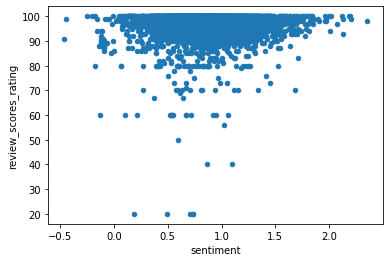

In [13]:
bnb_data.plot.scatter(x='sentiment', y='review_scores_rating')

In [19]:
bnb_data.dtypes

id                                                int64
listing_url                                      object
scrape_id                                       float64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

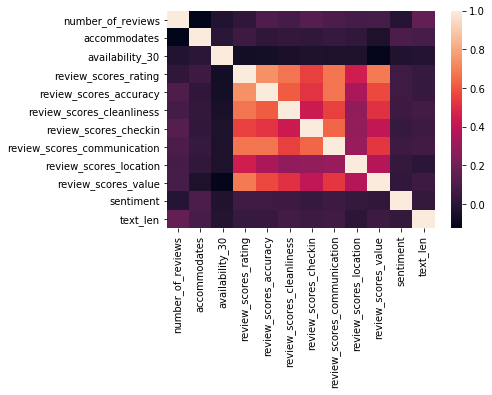

In [31]:
mat = bnb_data[['number_of_reviews', 'accommodates', 'availability_30', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'sentiment', 'text_len']].corr()
sns.heatmap(mat)
